# Домашняя работа №3

При отправлении ДЗ в Dropbox указывайте фамилию в названии файла: <br\>
** IDA<Номер группы>HW3<Фамилия>.ipynb ** - например ** IDA3HW3Pupkin.ipynb **<br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

# Преамбула

Автоэнкодеры - это полносвязные сети, задачей которых является на выходе сети восстановить объекты, поданные на вход. Такие сети состоят из двух частей - енкодера и декодера. В каждом следующем слое энкодера становится всё меньше и меньше нейронов, в результате чего происходит "сжатие" исходной информации. В самом сжатом виде информация находится на последнем слое энкодера который называется bottleneck(с англ. бутылочное горлышко). Далее информация из bottleneck'a подаётся на вход декодеру, у которого наоборот с каждый следующим слоем количество нейронов становится больше и больше. Размерности выходов и входов такой нейронной сети совпадают. 

<img src="autoencoder.png">

Активации нейронов с самого узкого слоя можно использовать как довольно качественные признаки для передачи в другие модели машинного обучения.

Целью данного домашнего задания является реализация нескольких вариантов автокодировщиков, проведение экспериментов с целью определения структур, которые выучивают нейроны. 

In [1]:
import numpy

import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Загрузка и предобработка данных(2.5 балла).

Загрузите *images.pkl*. Данный файл содержит набор фото. 

In [2]:
import pickle as pkl
import numpy as np
images = np.zeros((2000,120,120,3))
for i in range(0,2000):
    images[i] = np.load(open("C:/Users/AliceP/Desktop/УЧЁБА/IAD/3kurs/dz3/images/%d.npy" % i, 'br'))

In [3]:
#не хватает озу 

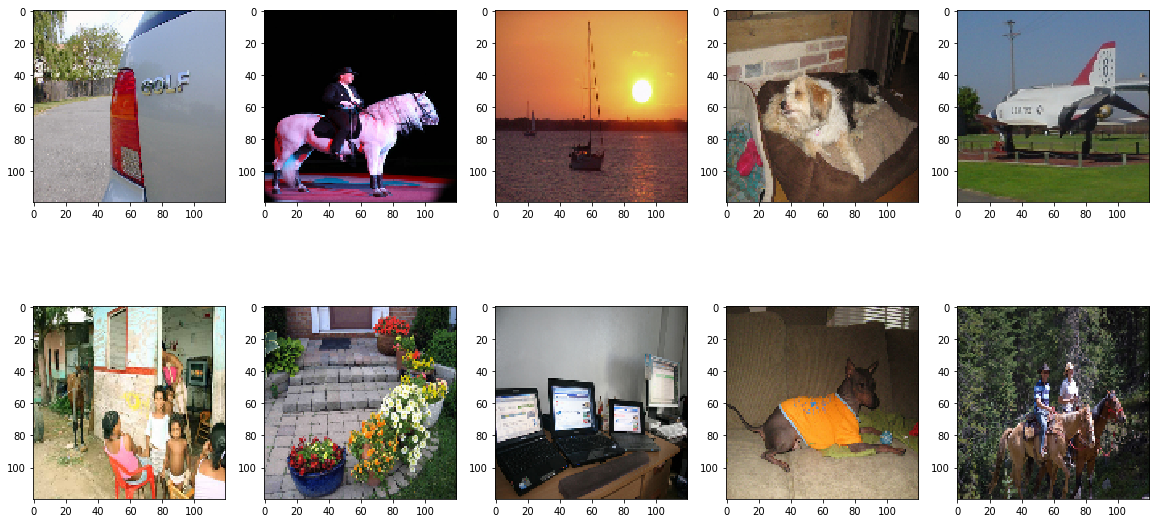

In [4]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])

## Генерация датасета(2 балла)

Напишите функцию, которая принимает на вход исходный набор фотографий из возращает нужное количество "сэмплов" - случайных квадратных подкартинок нужного размера. Визуализируйте несколько сэмплов.

In [5]:
import random

In [31]:
random.seed(123)

In [32]:
num_samples=10000

In [68]:
def get_samples(full_images, num_samples=10000, sample_size=16, rand_seed=123):
    # входные параметры
    # full_images: np.array, исходный датасет
    # num_samples: int, количество патчей, которые функция должна вернуть
    # sample_size: int, длина стороны каждого патча
    # rand_seed: int, число для инициализации np.random.seed, чтобы генерация датасета была воспроизводимой
   
    # выход функции
    # np.array размера [num_samples, sample_size, sample_size, 3]
    random.seed(rand_seed)
    indx = np.array([random.randint(0, images.shape[0]-1) for i in range(num_samples)])
    side1 = random.randint(0, images.shape[1]-sample_size)
    side2 = random.randint(0, images.shape[2]-sample_size)
    new_samples = images[indx,side1:side1+sample_size, side2:side2+sample_size, :]
    return new_samples
    ##pass

In [69]:
images.shape

(2000, 120, 120, 3)

In [71]:
new_samples = get_samples(images)

In [72]:
new_samples.shape

(10000, 16, 16, 3)

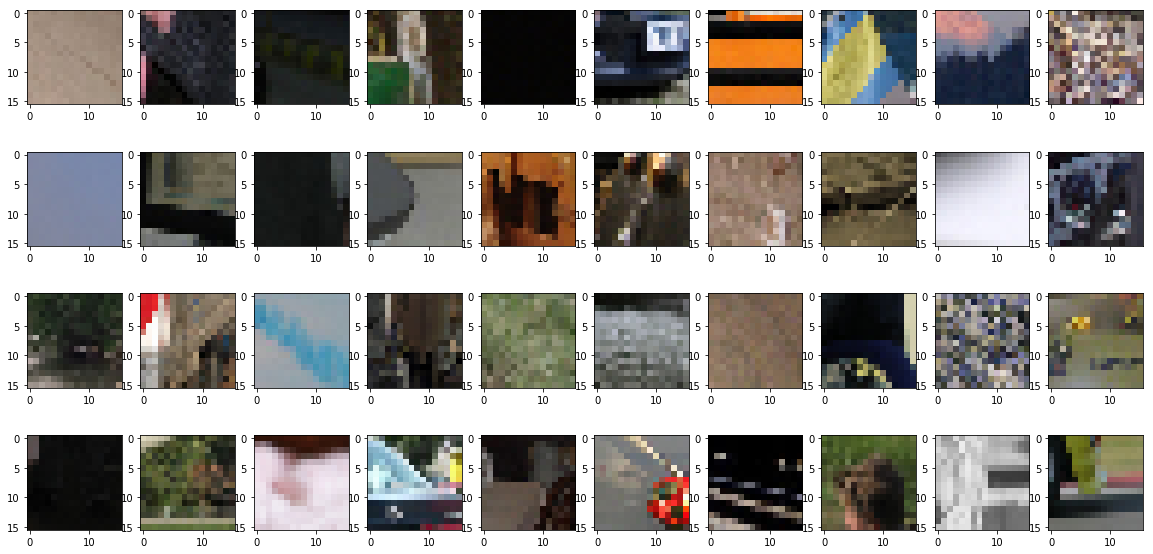

In [73]:
plt.figure(figsize=(20, 10))

for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(new_samples[i])

## Нормировка картинок и вытягивание их в один вектор(0.5 балл)

Переведите интенсивности каждого канала (R, G, B) в отрезок $[0.1, 0.9]$. Значения отбрасывать не надо, просто отшкалируйте каналы.

In [76]:
MIN = 0.1
MAX = 0.9

In [77]:
scaled_samples = new_samples * (MAX - MIN) + MIN

In [78]:
print (np.max(scaled_samples[:, :, :,0]), 
np.max(scaled_samples[:, :, :,1]), 
np.max(scaled_samples[:, :, :,2]))
print (np.min(scaled_samples[:, :, :,0]), 
np.min(scaled_samples[:, :, :,1]), 
np.min(scaled_samples[:, :, :,2]))

0.9 0.9 0.9
0.1 0.1 0.1


Преобразуйте каждый семпл-матрицу в вектор.

То есть из исходного набора сэмплов размера [num_samples, sample_size, sample_size, 3] должен получиться набор размера [num_samples, sample_size x sample_size x 3].

In [79]:
scaled_samples.shape

(10000, 16, 16, 3)

In [81]:
scaled_samples[0].shape[0]*scaled_samples[0].shape[1]*scaled_samples[0].shape[2]

768

In [86]:
#16*3*3=768

In [97]:
flatten_samples = np.zeros((num_samples,768))
for i in range (num_samples):
    flatten_samples[i] = scaled_samples[i].flatten()

In [98]:
flatten_samples.shape

(10000, 768)

# Реализация и обучение автокодировщика(4 балла)

### Построение автокодировщика(1.5 балла)

Напишите функцию, которая принимает параметры автокодировщика(размер входа и выхода, количества нейронов в каждом слое энкодера, количество нейронов в каждом слое декодера). Внутри автокодировщика использовать нелинейности-RELU. Но для выходов автоэнкодера использовать сигмоиду.

Выход функции - Keras модель, скомпилированная чтобы минимизировать MSE на трэйне. Оптимизатор - на ваш выбор.

In [99]:
from keras.layers import Dense
from keras.models import Sequential

In [100]:
def create_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[200, 400]):
    # входные параметры:
    # object_size: int, размер входного и выходного слоя автоэнкодера
    # encoder_layer_shapes: list of int, количество нейронов в каждом слое энкодера. 
    #                       последний элемент списка - размер "бутылочного горлышка"
    # decoder_layer_shapes: ist of int, количество нейронов в каждом слое декодера
    
    # выход:
    # keras модель
    
    model = Sequential()
    model.add(Dense(encoder_layer_shapes[0], input_dim=object_size, activation='relu'))
    model.add(Dense(encoder_layer_shapes[1], activation='relu'))
    model.add(Dense(encoder_layer_shapes[2], activation='relu'))
    
    model.add(Dense(decoder_layer_shapes[0], activation='relu'))
    model.add(Dense(decoder_layer_shapes[1], activation='relu'))
    model.add(Dense(object_size, activation='sigmoid'))
    
    return model

Разделите выборку из сэмплов на тренировочную выборку и валидационную отношении 90%-10%.

In [101]:
train_size = int(len(flatten_samples)* 0.9)
train, val = flatten_samples[0:train_size,:], flatten_samples[train_size:len(flatten_samples),:]
print(len(train), len(val))

9000 1000


Обучите модель со стандартными параметрами.

In [102]:
autoencoder = create_autoencoder_model()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(flatten_samples, flatten_samples, epochs=15, validation_split=0.1, batch_size=20)

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0177 - acc: 0.0092 - val_loss: 0.0109 - val_acc: 0.0130
Epoch 2/15
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0096 - acc: 0.0120 - val_loss: 0.0091 - val_acc: 0.0180
Epoch 3/15
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0083 - acc: 0.0156 - val_loss: 0.0078 - val_acc: 0.0150
Epoch 4/15
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0075 - acc: 0.0159 - val_loss: 0.0074 - val_acc: 0.0180
Epoch 5/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0070 - acc: 0.0211 - val_loss: 0.0069 - val_acc: 0.0300
Epoch 6/15
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0066 - acc: 0.0211 - val_loss: 0.0064 - val_acc: 0.0250
Epoch 7/15
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0063 - acc: 0.0240 - val_loss: 0.0062 - val_acc: 0.0200
Epoch 8

### Визуализация паттернов, которые находят нейроны(1.5 балла)

Возьмите несколько объектов из валидационной выборки и прогоните через автоэнкодер. Оцените визуально результат восстановления объектов.

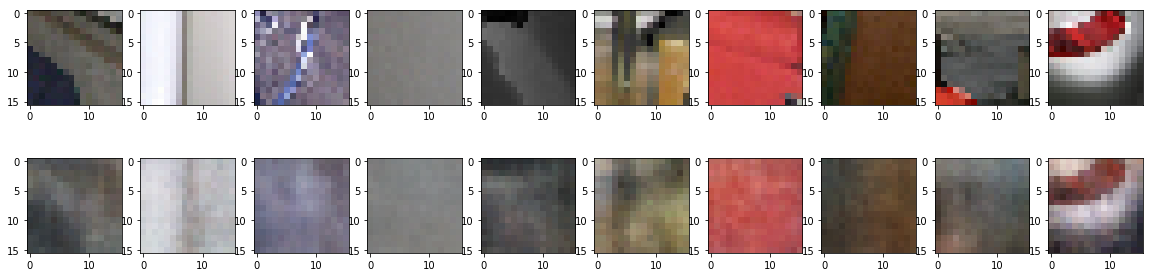

In [103]:
pred_samples = autoencoder.predict(val)
vost_res = np.zeros((pred_samples.shape[0],16,16,3))
for i in range(pred_samples.shape[0]):
    vost_res[i] = pred_samples[i].reshape((16,16,3))
    
plt.figure(figsize=(20, 5))

for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(new_samples[train_size+i])
    plt.subplot(2, 10, i+11)
    plt.imshow(vost_res[i])

Для каждого слоя и для каждого нейрона на этом слое найдите объект из тренировочной выборки, на котором этот нейрон выдаёт наибольшую активацию. Если нейрон ни на одном объекте не активировался, пропустите изображение для него. Что можете сказать про сложность шаблонов на объектах для каждого слоя?

In [104]:
from keras import backend as K

# with a Sequential model

In [105]:
def get_activation_layer(model,X,k):
    get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[k].output])
    layer_output = get_layer_output([X])[0]
    return layer_output.argmax(axis=0)

In [109]:
#для 1 слоя

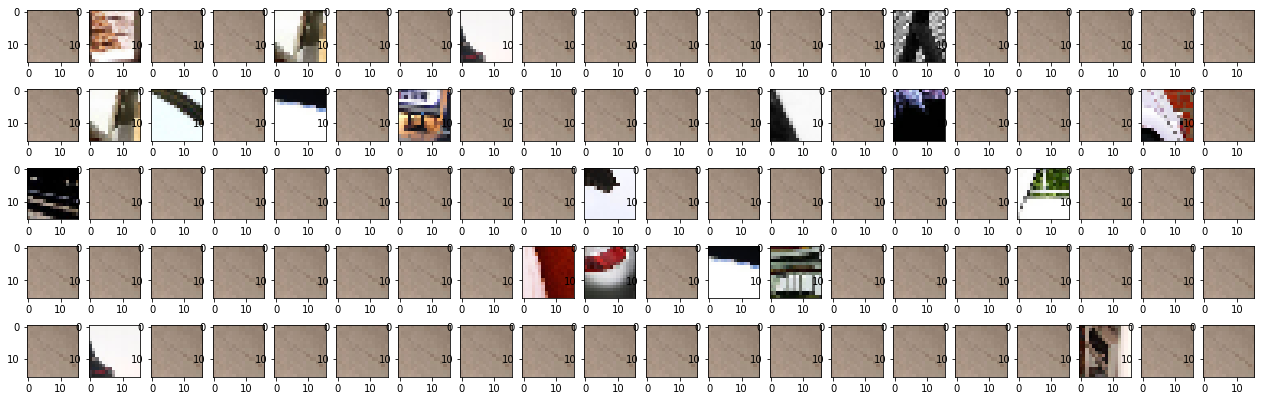

In [117]:
plt.figure(figsize=(22, 7))
layer = get_activation_layer(autoencoder,train,0)[:100]
    
for i,j in enumerate(layer):
    plt.subplot(5, 20, i+1)
    plt.imshow(new_samples[j])

In [121]:
#для 2 слоя

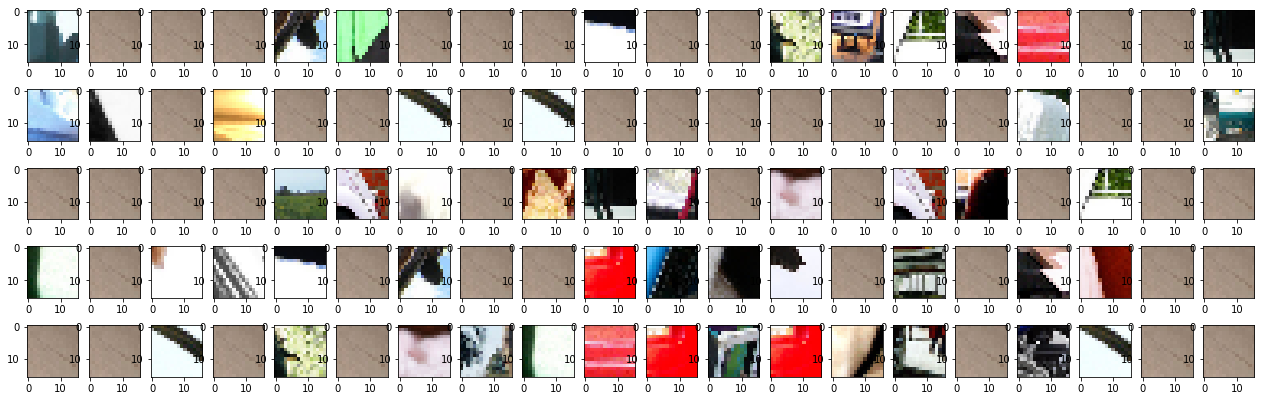

In [118]:
plt.figure(figsize=(22, 7))
layer = get_activation_layer(autoencoder,train,1)[:100]
    
for i,j in enumerate(layer):
    plt.subplot(5, 20, i+1)
    plt.imshow(new_samples[j])

In [112]:
#для 3 слоя

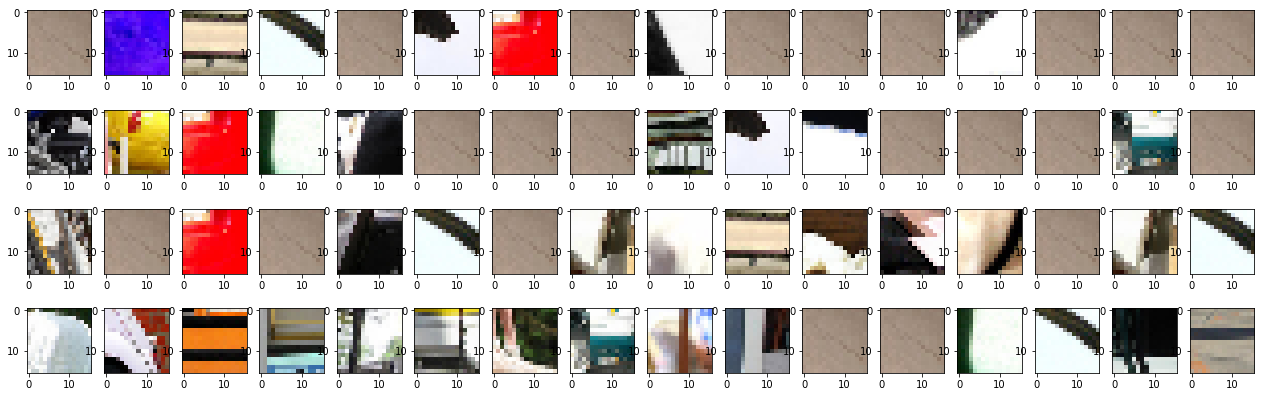

In [124]:
plt.figure(figsize=(22, 7))
layer = get_activation_layer(autoencoder,train,2)[:64]
    
for i,j in enumerate(layer):
    plt.subplot(4, 16, i+1)
    plt.imshow(new_samples[j])

In [114]:
#для 4 слоя

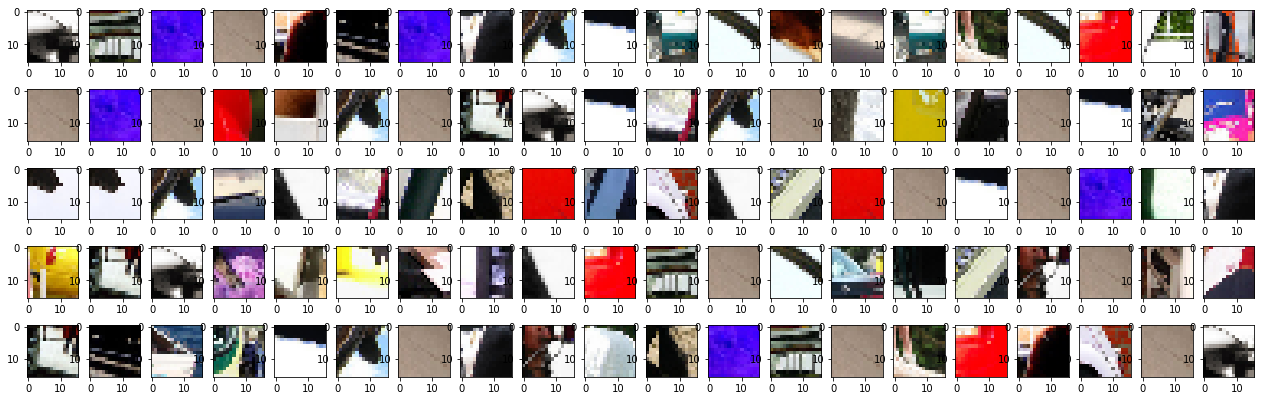

In [122]:
plt.figure(figsize=(22, 7))
layer = get_activation_layer(autoencoder,train,3)[:100]
    
for i,j in enumerate(layer):
    plt.subplot(5, 20, i+1)
    plt.imshow(new_samples[j])

In [123]:
#для 5 слоя

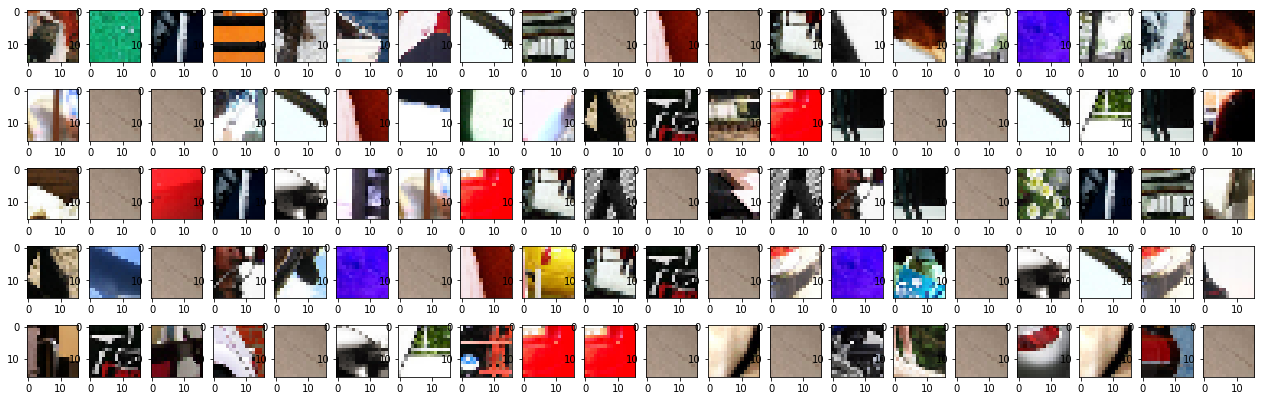

In [127]:
plt.figure(figsize=(22, 7))
layer = get_activation_layer(autoencoder,train,4)[:100]
    
for i,j in enumerate(layer):
    plt.subplot(5, 20, i+1)
    plt.imshow(new_samples[j])

In [126]:
#для 6 слоя

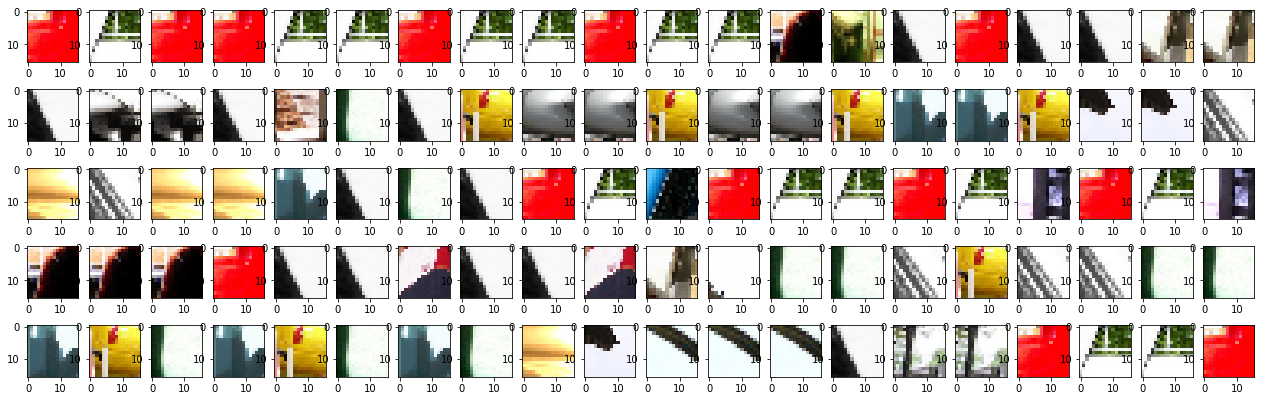

In [128]:
plt.figure(figsize=(22, 7))
layer = get_activation_layer(autoencoder,train,5)[:100]
    
for i,j in enumerate(layer):
    plt.subplot(5, 20, i+1)
    plt.imshow(new_samples[j])

Вывод: шаблоны становятся сложнее с каждым слоем

### Исследование зависимости качества восстановления от параметров автоэнкодера (1 балл)


Обучите несколько автоэнкодеров с различным количеством слоёв, разными размерами bottleneck'a и сравните, насколько быстро модели обучаются и финальный лосс на валидационной выборке. Какие выводы вы можете сделать?

In [130]:
#меньше слоев
def create_autoencoder_model1(object_size=768, encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[200, 400]):
    model = Sequential()
    model.add(Dense(encoder_layer_shapes[0], input_dim=object_size, activation='relu'))
    #model.add(Dense(encoder_layer_shapes[1], activation='relu'))
    model.add(Dense(encoder_layer_shapes[2], activation='relu'))
    
    #model.add(Dense(decoder_layer_shapes[0], activation='relu'))
    model.add(Dense(decoder_layer_shapes[1], activation='relu'))
    model.add(Dense(object_size, activation='sigmoid'))
    
    return model

In [131]:
#больше слоев
def create_autoencoder_model2(object_size=768, encoder_layer_shapes=[444, 256, 144, 64], decoder_layer_shapes=[80, 200, 400]):
    model = Sequential()
    model.add(Dense(encoder_layer_shapes[0], input_dim=object_size, activation='relu'))
    model.add(Dense(encoder_layer_shapes[1], activation='relu'))
    model.add(Dense(encoder_layer_shapes[2], activation='relu'))
    model.add(Dense(encoder_layer_shapes[3], activation='relu'))
    
    
    model.add(Dense(decoder_layer_shapes[0], activation='relu'))
    model.add(Dense(decoder_layer_shapes[1], activation='relu'))
    model.add(Dense(decoder_layer_shapes[2], activation='relu'))
    model.add(Dense(object_size, activation='sigmoid'))
    
    return model

In [132]:
#уменьшим бутылочное горлышко
def create_autoencoder_model3(object_size=768, encoder_layer_shapes=[256, 144, 32], decoder_layer_shapes=[200, 400]):
    model = Sequential()
    model.add(Dense(encoder_layer_shapes[0], input_dim=object_size, activation='relu'))
    model.add(Dense(encoder_layer_shapes[1], activation='relu'))
    model.add(Dense(encoder_layer_shapes[2], activation='relu'))
    
    model.add(Dense(decoder_layer_shapes[0], activation='relu'))
    model.add(Dense(decoder_layer_shapes[1], activation='relu'))
    model.add(Dense(object_size, activation='sigmoid'))
    
    return model

In [133]:
#увеличим бутылочное горлышко
def create_autoencoder_model4(object_size=768, encoder_layer_shapes=[256, 144, 80], decoder_layer_shapes=[200, 400]):
    model = Sequential()
    model.add(Dense(encoder_layer_shapes[0], input_dim=object_size, activation='relu'))
    model.add(Dense(encoder_layer_shapes[1], activation='relu'))
    model.add(Dense(encoder_layer_shapes[2], activation='relu'))
    
    model.add(Dense(decoder_layer_shapes[0], activation='relu'))
    model.add(Dense(decoder_layer_shapes[1], activation='relu'))
    model.add(Dense(object_size, activation='sigmoid'))
    
    return model

In [134]:
autoencoder = create_autoencoder_model1()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(flatten_samples, flatten_samples, epochs=15, validation_split=0.1, batch_size=20)

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0197 - acc: 0.0100 - val_loss: 0.0106 - val_acc: 0.0180
Epoch 2/15
9000/9000 [==============================] - 10s 1ms/step - loss: 0.0097 - acc: 0.0134 - val_loss: 0.0091 - val_acc: 0.0150
Epoch 3/15
9000/9000 [==============================] - 10s 1ms/step - loss: 0.0084 - acc: 0.0158 - val_loss: 0.0079 - val_acc: 0.0190
Epoch 4/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0076 - acc: 0.0176 - val_loss: 0.0073 - val_acc: 0.0130
Epoch 5/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0071 - acc: 0.0181 - val_loss: 0.0070 - val_acc: 0.0080
Epoch 6/15
9000/9000 [==============================] - 10s 1ms/step - loss: 0.0068 - acc: 0.0177 - val_loss: 0.0067 - val_acc: 0.0160
Epoch 7/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0067 - acc: 0.0208 - val_loss: 0.0065 - val_acc: 0.0170
Epoch 8

In [135]:
autoencoder = create_autoencoder_model2()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(flatten_samples, flatten_samples, epochs=15, validation_split=0.1, batch_size=20)

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 17s 2ms/step - loss: 0.0203 - acc: 0.0071 - val_loss: 0.0127 - val_acc: 0.0110
Epoch 2/15
9000/9000 [==============================] - 16s 2ms/step - loss: 0.0118 - acc: 0.0080 - val_loss: 0.0114 - val_acc: 0.0100
Epoch 3/15
9000/9000 [==============================] - 16s 2ms/step - loss: 0.0107 - acc: 0.0083 - val_loss: 0.0102 - val_acc: 0.0100
Epoch 4/15
9000/9000 [==============================] - 16s 2ms/step - loss: 0.0098 - acc: 0.0117 - val_loss: 0.0096 - val_acc: 0.0080
Epoch 5/15
9000/9000 [==============================] - 16s 2ms/step - loss: 0.0092 - acc: 0.0122 - val_loss: 0.0092 - val_acc: 0.0090
Epoch 6/15
9000/9000 [==============================] - 16s 2ms/step - loss: 0.0089 - acc: 0.0132 - val_loss: 0.0088 - val_acc: 0.0120
Epoch 7/15
9000/9000 [==============================] - 16s 2ms/step - loss: 0.0086 - acc: 0.0162 - val_loss: 0.0086 - val_acc: 0.0180
Epoch 8

In [136]:
autoencoder = create_autoencoder_model3()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(flatten_samples, flatten_samples, epochs=15, validation_split=0.1, batch_size=20)

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0182 - acc: 0.0078 - val_loss: 0.0114 - val_acc: 0.0110
Epoch 2/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0101 - acc: 0.0108 - val_loss: 0.0099 - val_acc: 0.0170
Epoch 3/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0094 - acc: 0.0129 - val_loss: 0.0097 - val_acc: 0.0130
Epoch 4/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0090 - acc: 0.0149 - val_loss: 0.0087 - val_acc: 0.0140
Epoch 5/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0086 - acc: 0.0160 - val_loss: 0.0086 - val_acc: 0.0150
Epoch 6/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0084 - acc: 0.0158 - val_loss: 0.0083 - val_acc: 0.0110
Epoch 7/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0082 - acc: 0.0187 - val_loss: 0.0086 - val_acc: 0.0060
Epoch 8

In [137]:
autoencoder = create_autoencoder_model4()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(flatten_samples, flatten_samples, epochs=15, validation_split=0.1, batch_size=20)

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 13s 1ms/step - loss: 0.0177 - acc: 0.0066 - val_loss: 0.0107 - val_acc: 0.0040
Epoch 2/15
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0096 - acc: 0.0126 - val_loss: 0.0092 - val_acc: 0.0080
Epoch 3/15
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0084 - acc: 0.0141 - val_loss: 0.0079 - val_acc: 0.0150
Epoch 4/15
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0076 - acc: 0.0176 - val_loss: 0.0074 - val_acc: 0.0110
Epoch 5/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0071 - acc: 0.0201 - val_loss: 0.0070 - val_acc: 0.0190
Epoch 6/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0067 - acc: 0.0211 - val_loss: 0.0070 - val_acc: 0.0210
Epoch 7/15
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0064 - acc: 0.0222 - val_loss: 0.0062 - val_acc: 0.0160
Epoch 8

In [138]:
# изначальная модель       13s 1ms/step - loss: 0.0046 - acc: 0.0386 - val_loss: 0.0047 - val_acc: 0.0450
# меньше слоев             10s 1ms/step - loss: 0.0056 - acc: 0.0243 - val_loss: 0.0057 - val_acc: 0.0200
# больше слоев             16s 2ms/step - loss: 0.0066 - acc: 0.0213 - val_loss: 0.0066 - val_acc: 0.0230
# уменьшили бут.горлышко   11s 1ms/step - loss: 0.0067 - acc: 0.0202 - val_loss: 0.0067 - val_acc: 0.0170
# увеличили бут.горлышко   12s 1ms/step - loss: 0.0046 - acc: 0.0369 - val_loss: 0.0047 - val_acc: 0.0270

#вывод: изначальная модель лучше, увеличение бут.горлышка и уменьшение слоев тоже норм
#увеличение слоев и бут.горлышка ухудшает модель

# Классификация MNIST и CIFAR (3,5 балла)

### MNIST (2 балла)

Загрузите датасет MNIST и провизуализируйте несколько цифр.

In [139]:
from keras.datasets import mnist

In [140]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 29s 3us/step


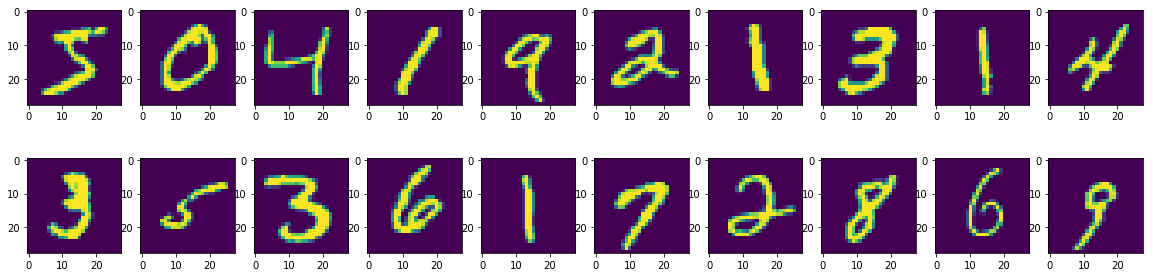

In [141]:
plt.figure(figsize=(20, 5))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_train[i])

Сожмите данные автокодировщиком, у которого только один скрытый слой(по сути только bottleneck) с 30 нейронами.

In [142]:
x_train.shape

(60000, 28, 28)

In [143]:
#28*28=784

In [145]:
flatten_x = np.zeros((x_train.shape[0],784))
for i in range (x_train.shape[0]):
    flatten_x[i] = x_train[i].flatten()/255 #нормализуем

In [152]:
flatten_x_test = np.zeros((x_test.shape[0],784))
for i in range (x_test.shape[0]):
    flatten_x_test[i] = x_test[i].flatten()/255

In [146]:
def create_autoencoder_model_one_layer(object_size=784, encoder_layer_shapes=[30]):
    
    model = Sequential()
    model.add(Dense(encoder_layer_shapes[0], input_dim=object_size, activation='relu'))
    model.add(Dense(object_size, activation='sigmoid'))
    
    return model

In [151]:
autoencoder = create_autoencoder_model_one_layer()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(flatten_x, flatten_x, epochs=15, batch_size=200)

Epoch 1/15
60000/60000 [==============================] - 6s 107us/step - loss: 0.0640 - acc: 0.0109
Epoch 2/15
60000/60000 [==============================] - 5s 92us/step - loss: 0.0323 - acc: 0.0098
Epoch 3/15
60000/60000 [==============================] - 5s 80us/step - loss: 0.0239 - acc: 0.0096
Epoch 4/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.0192 - acc: 0.0095
Epoch 5/15
60000/60000 [==============================] - 5s 87us/step - loss: 0.0164 - acc: 0.0115
Epoch 6/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.0146 - acc: 0.0122
Epoch 7/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.0134 - acc: 0.0127
Epoch 8/15
60000/60000 [==============================] - 5s 88us/step - loss: 0.0126 - acc: 0.0128
Epoch 9/15
60000/60000 [==============================] - 5s 89us/step - loss: 0.0121 - acc: 0.0131
Epoch 10/15
60000/60000 [==============================] - 5s 89us/step - loss: 0.0118 - acc: 0.013

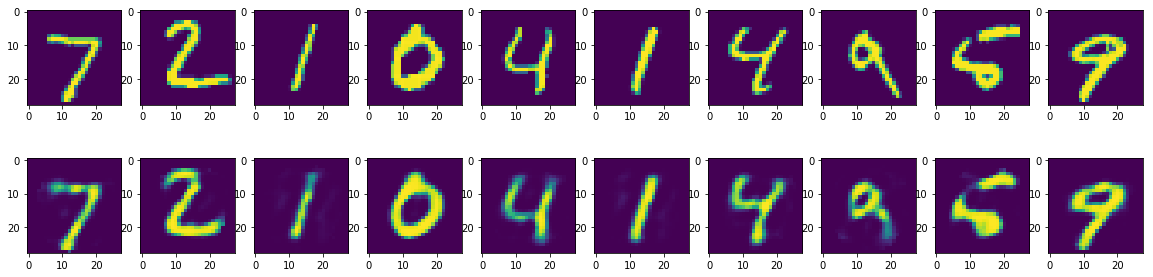

In [153]:
pred_samples = autoencoder.predict(flatten_x_test)
vost_res = np.zeros((pred_samples.shape[0],28,28))
for i in range(pred_samples.shape[0]):
    vost_res[i] = pred_samples[i].reshape((28,28))

plt.figure(figsize=(20, 5))

for i in range(10):
    plt.subplot(2, 10, i+11)
    plt.imshow(vost_res[i])
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[i])

Возьмите несколько моделей из sklearn (KNN,SVM, RandomForest, GradientBoosting/XGBClassifier) и обучите модель со стандартными параметрами на выходах энкодера. Какие у вас получились результаты(точность) на тесте?

In [155]:
get_layer_output = K.function([autoencoder.layers[0].input],
                              [autoencoder.layers[0].output])
layer_output = get_layer_output([flatten_x])[0]

In [172]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC

In [173]:
from sklearn.metrics import accuracy_score

In [174]:
#возьму первые 10000, чтобы было быстрее

In [175]:
layer_output_test = get_layer_output([flatten_x_test])[0]

In [176]:
clf1 = SVC()
clf1.fit(layer_output[:10000],y_train[:10000])
accuracy_svc = accuracy_score(clf1.predict(layer_output_test),y_test)

In [177]:
clf2 = RFC()
clf2.fit(layer_output[:10000],y_train[:10000])
accuracy_rfc = accuracy_score(clf2.predict(layer_output_test),y_test)

In [178]:
clf3 = KNC()
clf3.fit(layer_output[:10000],y_train[:10000])
accuracy_knc = accuracy_score(clf3.predict(layer_output_test),y_test)

In [179]:
print("SVC: Accuracy score = ",accuracy_svc)
print("RFC: Accuracy score = ",accuracy_rfc)
print("KNC: Accuracy score = ",accuracy_knc)

SVC: Accuracy score =  0.6348
RFC: Accuracy score =  0.8585
KNC: Accuracy score =  0.9438


### CIFAR10(2 балла)

Загрузите CIFAR10 и обучите автоэнкодер на случайных сэмплах размера 8x8 из этого датасета. Архитектура автоэнкодера как в прошлом пункте - только один внутренний слой из 30 нейронов.

In [197]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [198]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [199]:
#8*8*3 = 192

In [213]:
sample_x_train = get_samples(x_train,num_samples=50000,sample_size=8)
sample_x_test = get_samples(x_test,num_samples=10000,sample_size=8)

flatten_x_train = np.zeros((sample_x_train.shape[0],192))
for i in range (sample_x_train.shape[0]):
    flatten_x_train[i] = sample_x_train[i].flatten()
    
flatten_x_test = np.zeros((sample_x_test.shape[0],192))
for i in range (sample_x_test.shape[0]):
    flatten_x_test[i] = sample_x_test[i].flatten()

In [205]:
def create_autoencoder_model_CIFAR10(object_size=192, encoder_layer_shapes=[30]):
    
    model = Sequential()
    model.add(Dense(encoder_layer_shapes[0], input_dim=object_size, activation='relu'))
    model.add(Dense(object_size, activation='sigmoid'))
    
    return model

In [220]:
autoencoder = create_autoencoder_model_CIFAR10()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(flatten_x_train, flatten_x_train, epochs=10, batch_size=20)

Epoch 1/10
50000/50000 [==============================] - 9s 177us/step - loss: 0.0154 - acc: 0.0681
Epoch 2/10
50000/50000 [==============================] - 9s 174us/step - loss: 0.0062 - acc: 0.1273
Epoch 3/10
50000/50000 [==============================] - 9s 172us/step - loss: 0.0055 - acc: 0.1467
Epoch 4/10
50000/50000 [==============================] - 9s 185us/step - loss: 0.0052 - acc: 0.1461
Epoch 5/10
50000/50000 [==============================] - 9s 175us/step - loss: 0.0051 - acc: 0.1501
Epoch 6/10
50000/50000 [==============================] - 8s 163us/step - loss: 0.0051 - acc: 0.1564
Epoch 7/10
50000/50000 [==============================] - 8s 161us/step - loss: 0.0050 - acc: 0.1587
Epoch 8/10
50000/50000 [==============================] - 8s 157us/step - loss: 0.0050 - acc: 0.1593
Epoch 9/10
50000/50000 [==============================] - 8s 161us/step - loss: 0.0050 - acc: 0.1611
Epoch 10/10
50000/50000 [==============================] - 8s 162us/step - loss: 0.0050 - a

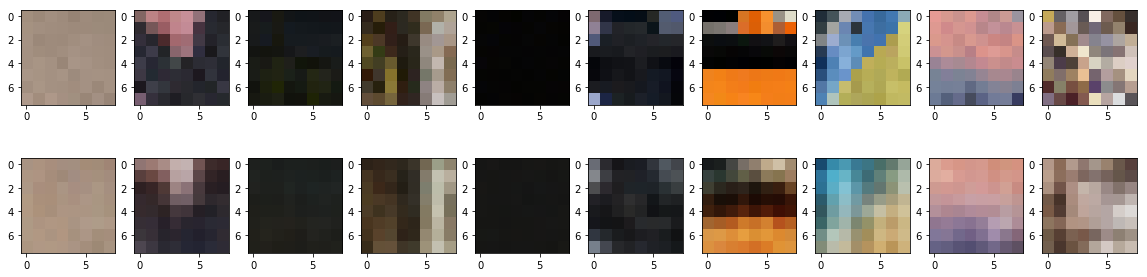

In [221]:
pred_samples = autoencoder.predict(flatten_x_test)
vos_res = np.zeros((pred_samples.shape[0],8,8,3))
for i in range(pred_samples.shape[0]):
    vos_res[i] = pred_samples[i].reshape((8,8,3))

plt.figure(figsize=(20, 5))

for i in range(10):
    plt.subplot(2, 10, i+11)
    plt.imshow(vos_res[i])
    plt.subplot(2, 10, i+1)
    plt.imshow(sample_x_test[i])

Теперь разделите каждую картинку из датасета на 16 сэмплjd размера 8x8, закодируйте их через энкодер и склейте 16 выходов энкодера в один вектор. Каждый объект в итоге должен кодироваться 16 * 30 = 380 признаками.

In [223]:
x_train[0].shape

(32, 32, 3)

In [225]:
x_train.shape

(50000, 32, 32, 3)

In [235]:
def pictures(images):
    pics = np.zeros((images.shape[0]*16,8,8,3))
    for k in range (images.shape[0]):
        for i in range(0,4):
            for j in range(0,4):
                pic=images[k,i*8:i*8+8,j*8:j*8+8,:]
                pics[k*16+i*4+j]=pic
    return pics

In [236]:
pics_train = pictures(x_train[:10000])
pics_test = pictures(x_test[:2500])
pics_train.shape

(160000, 8, 8, 3)

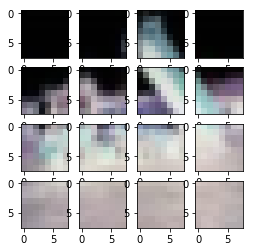

In [241]:
plt.figure(figsize=(4, 4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(pics_train[i+32])

In [242]:
flatten_x_train = np.zeros((pics_train.shape[0],192))#192 = 8*8*3
for i in range (pics_train.shape[0]):
    flatten_x_train[i] = pics_train[i].flatten()/255
    
flatten_x_test = np.zeros((pics_test.shape[0],192))
for i in range (pics_test.shape[0]):
    flatten_x_test[i] = pics_test[i].flatten()/255

In [244]:
flatten_x = np.vstack((flatten_x_train,flatten_x_test)) #соединяем test и train

In [245]:
get_layer_output = K.function([autoencoder.layers[0].input],
                              [autoencoder.layers[0].output])
layer_output = get_layer_output([flatten_x])[0]

In [246]:
layer_output.shape

(200000, 30)

In [252]:
16*30

480

In [248]:
X = np.zeros((12500,480))
for i in range(12500):
    X[i] = layer_output[16*i:16*i+16].flatten()

Теперь обучите SVM на преобразованных объектах и выведите точность.

In [250]:
clf = SVC()
clf.fit(X[:10000],y_train[:10000]) #возьмем первые 10000 (быстрее)

C:\Users\AliceP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [251]:
as_svc = accuracy_score(clf.predict(X[10000:12500]),y_test[:2500])
print("SVC: Accuracy score = ",as_svc)

SVC: Accuracy score =  0.4684
